### Imports

In [1]:
# Load the extension and start TensorBoard

%load_ext tensorboard
%tensorboard --logdir logs

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter

### Defining the model

In [3]:
class CNN(nn.Module):
    def __init__(self, input_channels=1, num_size=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d( in_channels=in_channels, out_channels=8, kernel_size=(3,3), padding=(1,1), stride=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.fc1 = nn.Linear(16 * 7 * 7, num_size)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

### Hyperparameters

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

in_channels =1
num_classes = 10
num_epochs = 3
learning_rate = 0.001
batch_size = 64

### Getting the dataset

In [5]:
import pandas as pd

df = pd.read_csv('../input/digit-recognizer/train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df['label'].values

array([1, 0, 1, ..., 7, 6, 9])

In [7]:
 df.iloc[:,1:].values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
class getTrainDataset(Dataset):
    def __init__(self,csv_path='../input/digit-recognizer/train.csv'):
        
        df = pd.read_csv(csv_path)
        
        self.y = torch.from_numpy(df.iloc[:,0].values)
        self.x = torch.from_numpy(df.iloc[:, 1:].values)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [9]:
train_dataset = getTrainDataset()

In [10]:
x, y = train_dataset[100]

y, x.shape

(tensor(9), torch.Size([784]))

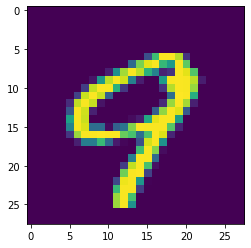

In [11]:
x = x.reshape(1, 28, 28)

import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))

In [12]:
train_dataset.__len__()

42000

In [13]:
train_dataloader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)

In [14]:
model = CNN().to(device=device)

In [15]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_criterion = nn.CrossEntropyLoss()

writer = SummaryWriter(f'runs/MNIST/trying_out_tensorboard')


In [16]:
step = 0
for epoch in range(num_epochs):
    total_correct = 0
    for data, target in tqdm(train_dataloader):
        data = data.reshape(data.shape[0],1,28,28).float()
        target = target.long()
        data = data.to(device=device)
        target = target.to(device=device)
        
        scores = model(data)
        loss = loss_criterion(scores, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predictions = scores.max(1)
        total_correct += (target==predictions).sum()
        accuracy = float(total_correct/target.shape[0])
        
        writer.add_scalar('training loss', loss, global_step=step)
        writer.add_scalar('training accuracy',accuracy, global_step=step )
        step += 1

100%|██████████| 657/657 [00:06<00:00, 96.21it/s]


In [17]:
def check_accuracy(model, loader):
    
    model.eval()
    
    total_correct = 0
    total_cases = 0
    
    for x,y in tqdm(loader):
        x = x.reshape(x.shape[0],1,28,28).float()
        y = y.long()
        x = x.to(device=device)
        y = y.to(device=device)
        
        scores = model(x)
        
        _, predictions = scores.max(1)
        total_correct += (y==predictions).sum()
        total_cases += y.shape[0]
        
    model.train()
    
    print(f"total correct: {total_correct} out of {total_cases} with an accuracy of {float(total_correct/total_cases)}")

In [18]:
check_accuracy(model, train_dataloader)

100%|██████████| 657/657 [00:03<00:00, 198.29it/s]

total correct: 41349 out of 42000 with an accuracy of 0.984499990940094
